# PELS tutorrial hands on

## Let us understand the system

* We query the system topology using LIKWID tool.
* Note that only 1 NUMA domain (16 cores) of CPU is available.
* Attached is also one A100 GPU.
* Watch out for the available cores.

In [4]:
!likwid-topology

--------------------------------------------------------------------------------
CPU name:	AMD EPYC 7713 64-Core Processor
CPU type:	AMD K19 (Zen3) architecture
CPU stepping:	1
********************************************************************************
Hardware Thread Topology
********************************************************************************
Sockets:		2
Cores per socket:	64
Threads per core:	1
--------------------------------------------------------------------------------
HWThread        Thread        Core        Die        Socket        Available
0               0             0           0          0                              
1               0             1           0          0                              
2               0             2           0          0                              
3               0             3           0          0                              
4               0             4           0          0                              


## CPU main memory bandwidth

* Main memory bandwidth is the most important hardware characteristic relevant to SpMV like kernels.
* Let us measure the bandwidth using LIKWID tool.
* Note that bandwidth of only 1 NUMA domain (16 cores) is measured.

In [5]:
!likwid-bench -t load_avx -w N:4GB:16

Allocate: Process running on hwthread 72 (Domain N) - Vector length 500000000/4000000000 Offset 0 Alignment 512
Initialization: First thread in domain initializes the whole stream
--------------------------------------------------------------------------------
LIKWID MICRO BENCHMARK
Test: load_avx
--------------------------------------------------------------------------------
Using 1 work groups
Using 16 threads
--------------------------------------------------------------------------------
Running without Marker API. Activate Marker API with -m on commandline.
--------------------------------------------------------------------------------
Group: 0 Thread 6 Global Thread 6 running on hwthread 78 - Vector length 31250000 Offset 187500000
Group: 0 Thread 7 Global Thread 7 running on hwthread 79 - Vector length 31250000 Offset 218750000
Group: 0 Thread 9 Global Thread 9 running on hwthread 81 - Vector length 31250000 Offset 281250000
Group: 0 Thread 11 Global Thread 11 running on hwthr

## Let us set up our environment

In [1]:
import sys
#On cluster we might not have internet to download packages
#so we set path to pre-installed Python packages
sys.path.insert(0, "/home/hpc/unrz/unrz002h/installkit/lib/python3.9/site-packages") 

import os
os.environ["USE_RACE"]="1" #Compile RACE too
os.environ["OMP_SCHEDULE"]="static"
os.environ["OMP_NUM_THREADS"]="4"

## Have a look at our main CG routine
* CG solver is implemented using the cg_solve function.
* Notice the kernels used for implementing CG solver.

In [6]:
from kernels import *
import numpy as np
import numba
import gc
from numpy.linalg import norm
from scipy.sparse import *
from scipy.io import mmread
from sellcs import sellcs_matrix
from poly_op import *


from matrix_generator import create_matrix
from pels_args import *

def cg_solve(A, b, x0, tol, maxit, verbose=False, x_ex=None):
    '''
    x, tol, iter = cg_solve(A, b, x0, tol, maxit)
    Where A is an spd scipy.sparse.csr_matrix, b and x0 are numpy.array's of size A.shpae[0],
    tol is the convergence tolerance and maxit the maximum number of iterations.
    '''
    x = clone(b)
    r = clone(b)
    p = clone(b)
    q = clone(b)

    err_norms=[]
    res_norms=[]
    
    if x_ex is not None:
        print('PerfWarning: providing the exact solution x_ex results in additional operations to calculate and print the error norm.')
        err = clone(b)

    tol2 = tol*tol


    axpby(1.0,x0,0.0,x)

    #r = A*x
    if hasattr(A, 'apply'):
        A.apply(x, r)
    else:
        spmv(A, x, r)
    #r = b - r
    axpby(1.0, b, -1.0, r)
    #p = r
    axpby(1.0, r, 0.0, p)

    # rho = <r, r>
    rho = dot(r,r);
    rho_old = 1.0
    if verbose:
        print('%d\t%e'%(0, np.sqrt(rho)))


    for iter in range(maxit+1):

        # check stop criteria
        if rho < tol2:
            break;

        # q = A*p
        if hasattr(A, 'apply'):
            A.apply(p, q)
        else:
            spmv(A, p, q)

        pq = dot(p,q)
        alpha = rho / pq
        # x = x+alpha*p
        axpby(alpha, p, 1.0, x)
        # r = r - alpha*q
        axpby(-alpha, q, 1.0, r)

        rho_old = rho
        rho = dot(r, r)

        curr_res_norm=np.sqrt(rho)
        res_norms.append(curr_res_norm)
        if x_ex is not None:
            if hasattr(A, 'unprec_sol'):
                A.unprec_sol(x, err)
            else:
                axpby(1.0, x, 0.0, err)
            axpby(-1.0, x_ex, 1.0, err)
            curr_err_norm=np.sqrt(dot(err, err))
            err_norms.append(curr_err_norm)    
            if verbose:
                print('%d\t%e\t%e'%(iter+1, curr_res_norm, curr_err_norm))
        else:   
            if verbose:
                print('%d\t%e'%(iter+1, curr_res_norm))

        beta = rho / rho_old
        # p = r+beta*p
        axpby (1.0, r, beta, p)

    iter_count = iter
    final_residual = np.sqrt(rho)

    return x, final_residual, iter_count, res_norms, err_norms




def pcg(matrix, maxit, mat_fmt='CSR', poly_k=0, tol=1e-3, use_RACE=False, cache_size=60, rand_seed=1, print_perf=False):
    ## **Note:** The Python garbage collector (gc)
    ## can kill the performance of the C kernels
    ## for some obscure reason (possibly a conflict
    ## between Numba/LLVM and other compilers like GCC).
    ## For the pure Python/numba/cuda kernels, this is not
    ## the case, but if you are facing obvious performnace
    ## problems with the C kernels, you may want to disalbe
    ## garbage collection:
    gc.disable()

    if rand_seed is not None:
        np.random.seed(rand_seed)

    #if args.matfile != 'None':
    #    if args.matgen!='None':
    #        print('got both -matfile and -matgen, the latter will be ignored.')
    #    if not args.matfile.endswith(('.mm','.mtx','.mm.gz','.mtx.gz')):
    #        raise(ValueError('Expecting MatrixMarket file with extension .mm[.gz] or .mtx[.gz]'))
    #    A = csr_matrix(mmread(args.matfile))
    A = create_matrix(matrix)
    N = A.shape[0]

    x_ex=np.random.rand(N)

    b=A*x_ex

    x0 = np.zeros(N,dtype='float64')

    print('norm of rhs: %e'%(norm(b)))
    print('rel. residual of given solution: %e'%(norm(A*x_ex-b)/norm(b)))

    sigma=1

    A_csr = A # we may need it for creating the preconditioner
              # in case the user wants a SELL-C-sigma matrix.

    print("nnz = ", A.nnz, "nrows =", N, "nnzr =", A.nnz/N)
    if 'SELL' in mat_fmt:
        C_=int(mat_fmt.split('-')[1])
        if C_ > 256:
            print('C greater than 256. Setting to maximum possible value 256')
            C_ = 256
        sigma_=int(mat_fmt.split('-')[2])
        print('Matrix format: SELL-%d-%d'%(C_,sigma_))
        A = sellcs_matrix(A_csr=A_csr, C=C_, sigma=sigma_)
        b = b[A.permute]
        A_csr = A_csr[A.permute[:,None], A.permute]
    else:
        print('Matrix format: CSR')

    if available_gpus()>0:
        type = 'gpu'
    else:
        type = 'cpu'

    print('Will run on '+type)
    
    numa=True
    
    if type=='gpu':
        x0 = to_device(x0)
        b  = to_device(b)
        A  = to_device(A)
        x_ex = to_device(x_ex)

    #Just run all the kernels one time. Just for catching any errors
    compile_all() 

    A_prec = A
    b_prec = b

    # we want to make sure what we measure during CG in total
    # is consistent with the sum of the kernel calls and their
    # runtime as predicted by the roofline model, so reset all
    # counters and timers:
    reset_counters()

    t0 = perf_counter()

    t0_pre = perf_counter()
    if poly_k>0:
        # building preconditioners typically requires a certain format,
        # in our case, the poly_op class uses scipy functions tril and triu,
        # which are not implemented by the sellcs_matrix class.
        print("calling poly_op ", poly_k)
        A_prec = poly_op(A_csr, poly_k, use_RACE, cache_size)
        if A_prec.mpkHandle != None:
            b = b[A_prec.permute]
            A_csr = A_csr[A_prec.permute[:,None], A_prec.permute]
        if 'SELL' in mat_fmt:
            # note: If A was originally sorted by row-length (sigma>1), use the same
            # sorting for L and U to avoid intermittent permutation by setting sigma=1.
            # There still seems to be some kind of bug, though, because the number of
            # iterations will increase with poly_k>0 and sigma>1. Hence this warning.
            C_=int(mat_fmt.split('-')[1])
            sigma_=int(mat_fmt.split('-')[2])
            A_prec.L = to_device(sellcs_matrix(A_csr=A_prec.L, C=C_, sigma=1))
            A_prec.U = to_device(sellcs_matrix(A_csr=A_prec.U, C=C_, sigma=1))
        b_prec = copy(b)
        A_prec.prec_rhs(b, b_prec)

    
    #hw_string = type
    #if type=='cpu':
    #    hw_string+=' ('+str(numba.threading_layer())+', '+str(numba.get_num_threads())+' threads)'
    #print('Hardware: '+hw_string)
    
    printerr=True
    x_ex_in = None
    if printerr:
        x_ex_in = x_ex  
        if poly_k>0:
            if A_prec.mpkHandle != None:
                x_ex_in = x_ex_in[A_prec.permute]

    t1_pre = perf_counter()

    t0_soln = perf_counter()
    x_prec, relres, iter, res_norms, err_norms = cg_solve(A_prec,b_prec,x0,tol,maxit, x_ex=x_ex_in)

    t1_soln = perf_counter()

    if poly_k>0:
        x = clone(x_prec)
        A_prec.unprec_sol(x_prec, x)
    else:
        x = x_prec

    t1 = perf_counter()
    t_pre = t1_pre-t0_pre
    t_soln = t1_soln-t0_soln
    t_CG = t1-t0
    gc.enable()

    x = to_host(x)

    rel_err_norms=err_norms/norm(x_ex)
    rel_res_norms=res_norms/norm(b)
    
    print('number of CG iterations: %d'%(iter))
    res = np.empty_like(x)
    spmv(A_csr,x,res)
    res=b-res
    print('relative residual of computed solution: %e'%(norm(res)/norm(b)))

    if 'SELL' in mat_fmt and sigma>1:
        x = x[A.unpermute]

    if poly_k>0:
        if A_prec.mpkHandle != None:
            x = x[A_prec.unpermute]

    print('relative error of computed solution: %e'%(norm(x-x_ex)/norm(x_ex)))

    if print_perf:
        perf_report(type)
    if poly_k>0:
        print('Total time for constructing precon: %g seconds.'%(t_pre))
        print('Total time for solving: %g seconds.'%(t_soln))
    print('Total time for CG: %g seconds.'%(t_CG))
    
    return rel_res_norms, rel_err_norms, iter, t_pre, t_soln, t_CG


## Let us run a simple example on CPU
* The matrix used is a simple 2D Laplacian of dimension 2000x2000.
* CG solver is run for 1000 iterations.
* At the end of the solver performance of each kernel used in CG is reported.
    * What is the most costly component?
    * Does the performance of SpMV match with the measured bandwidth?

In [12]:
os.environ["USE_CPU"]="True"
rel_res_in_CG, rel_err, iter, t_pre, t_soln, t_CG = pcg('Laplace200x200x200', 50, print_perf=True)

norm of rhs: 5.296921e+03
rel. residual of given solution: 0.000000e+00
nnz =  55760000 nrows = 8000000 nnzr = 6.97
Matrix format: CSR
Will run on cpu
number of CG iterations: 50
relative residual of computed solution: 2.070108e-03
relative error of computed solution: 6.313400e-01
Hardware assumed for Roofline Model: undefined
(roofline values will be skipped -- use cpu.json and/or gpu.json to provide memory bandwidth data)
Number of threads: 16
--------	-----	---------------	---------------	---------------
kernel  	calls	 bw_meas       	 meas          	 t_meas/call   
========	=====	===============	===============	===============
     dot	  154	   39.22 GB/s	  0.3345 s 	0.002172 s 	
   axpby	  258	   42.01 GB/s	   1.179 s 	0.004571 s 	
    spmv	   53	   32.08 GB/s	   1.423 s 	 0.02684 s 	
--------	-----	---------------	---------------
   Total	     	               	               	    2.936 s 
--------	-----	---------------	---------------
Total time for CG: 2.93862 seconds.


## Now let us run on GPU
* Notice that CG solver is much faster.
* Is it the best we can do on this GPU? (Hint: Bandwidth of one A100 is roughly around 1.5 TB/s) 

In [13]:
os.environ["USE_CPU"]="False"
rel_res_in_CG, rel_err, iter, t_pre, t_soln, t_CG = pcg('Laplace200x200x200', 200,  print_perf=True)

norm of rhs: 5.296921e+03
rel. residual of given solution: 0.000000e+00
nnz =  55760000 nrows = 8000000 nnzr = 6.97
Matrix format: CSR
Will run on gpu


/home/hpc/unrz/unrz002h/installkit/lib/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/hpc/unrz/unrz002h/installkit/lib/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/hpc/unrz/unrz002h/installkit/lib/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/hpc/unrz/unrz002h/installkit/lib/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/hpc/unrz/unrz002h/installkit/lib/python3.9/site-packages/numb

number of CG iterations: 200
relative residual of computed solution: 2.708818e-04
relative error of computed solution: 3.411134e-02
Hardware assumed for Roofline Model: undefined
(roofline values will be skipped -- use cpu.json and/or gpu.json to provide memory bandwidth data)
--------	-----	---------------	---------------	---------------
kernel  	calls	 bw_meas       	 meas          	 t_meas/call   
========	=====	===============	===============	===============
     dot	  604	   346.1 GB/s	  0.1489 s 	0.0002465 s 	
   axpby	 1008	   656.5 GB/s	  0.2948 s 	0.0002925 s 	
    spmv	  203	   823.4 GB/s	  0.2123 s 	0.001046 s 	
--------	-----	---------------	---------------
   Total	     	               	               	    0.656 s 
--------	-----	---------------	---------------
Total time for CG: 0.660838 seconds.


## Matrix formats
* See what happens if we switch to SELL-C-sigma matrix format.
* Try to increase C value (maximum possible value is 256) and observe what hapens.

In [16]:
os.environ["USE_CPU"]="False"
rel_res_in_CG, rel_err, iter, t_pre, t_soln, t_CG = pcg('Laplace200x200x200', 200,  mat_fmt='SELL-8-1', print_perf=True)

norm of rhs: 5.296921e+03
rel. residual of given solution: 0.000000e+00
nnz =  55760000 nrows = 8000000 nnzr = 6.97
Matrix format: SELL-8-1
Will run on gpu
number of CG iterations: 200
relative residual of computed solution: 2.708818e-04
relative error of computed solution: 3.411134e-02
Hardware assumed for Roofline Model: undefined
(roofline values will be skipped -- use cpu.json and/or gpu.json to provide memory bandwidth data)
--------	-----	---------------	---------------	---------------
kernel  	calls	 bw_meas       	 meas          	 t_meas/call   
========	=====	===============	===============	===============
     dot	  604	   312.2 GB/s	   0.165 s 	0.0002732 s 	
   axpby	 1008	     656 GB/s	   0.295 s 	0.0002927 s 	
    spmv	  203	   353.1 GB/s	   0.495 s 	0.002439 s 	
--------	-----	---------------	---------------
   Total	     	               	               	   0.9551 s 
--------	-----	---------------	---------------
Total time for CG: 0.963438 seconds.


## Preconditioner and its effects
* Now we will experiment with polynomial preconditioner.
* Let us stick with the CPU from now on.
* We will run the solver till the residual reaches 1e-2. Note: The entire run may take two minutes.
* Observe what happens as the degree of polynomial increases.
* How does it effect the CG iterations? How about time?

norm of rhs: 5.296921e+03
rel. residual of given solution: 0.000000e+00
nnz =  55760000 nrows = 8000000 nnzr = 6.97
Matrix format: CSR
Will run on cpu


KeyboardInterrupt: 

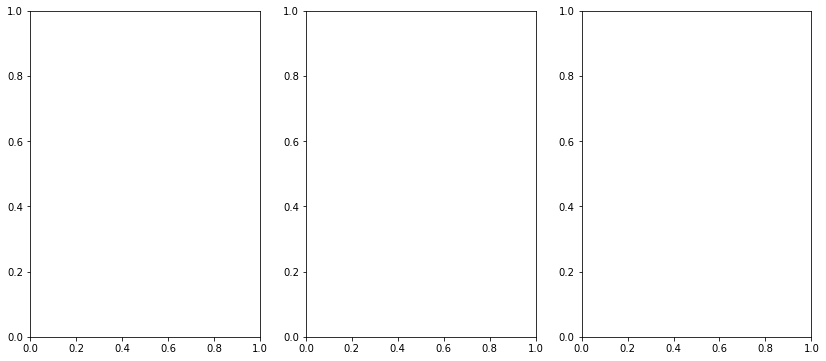

In [17]:
import matplotlib.pyplot as plt 
degrees=[]
iters=[]
times=[]
plt.subplots(1,3, figsize=(14,6))

os.environ["USE_CPU"]="True"
plt.subplot(1, 3, 1)
for deg in [0,1,2,3]:
    rel_res_in_CG, rel_err, iter, t_pre, t_soln, t_CG = pcg('Laplace200x200x200', 10000, poly_k=deg, tol=1e-12)
    degrees.append(deg)
    iters.append(iter)
    times.append(t_CG)
    plt.plot(rel_err, label="degree="+str(deg))

    
plt.xlabel("Iterations")
plt.ylabel("Relative error")
plt.legend()

plt.subplot(1, 3, 2)
plt.xlabel("Polynomial degree")
plt.ylabel("Iterations to convergence")
plt.plot(degrees, iters)

plt.subplot(1, 3, 3)
plt.xlabel("Polynomial degree")
plt.ylabel("Time to convergence")
plt.plot(degrees, times)

plt.tight_layout()
plt.show()

## Cache blocking using RACE
* We have seen RACE can allow us to cache block across multiple iterations of MPK solver.
* Let us experiment with the efficacy of this method.
* Try playing with the following knobs:
    * use_RACE: True or False to switch on or off RACE.
    * poly_k: The degree of polynomial.
    * cache_size: The cache size for which RACE will perform cache blocking.

In [ ]:
os.environ["USE_CPU"]="True"
rel_res_in_CG, rel_err, iter, t_pre, t_soln, t_CG = pcg('Laplace200x200x200', 50, poly_k=2, tol=1e-3, use_RACE=True, cache_size=60, print_perf=True)

norm of rhs: 5.296921e+03
rel. residual of given solution: 0.000000e+00
nnz =  55760000 nrows = 8000000 nnzr = 6.97
Matrix format: CSR
Will run on cpu
calling poly_op  2


## Does RACE impprove the time to solution for polynomial preconditioner?

In [ ]:
import matplotlib.pyplot as plt 
degrees=[]
iters=[]
times=[]
plt.subplots(1,3, figsize=(14,6))

os.environ["USE_CPU"]="True"
plt.subplot(1, 3, 1)
for deg in [0,1,2,3]:
    rel_res_in_CG, rel_err, iter, t_pre, t_soln, t_CG = pcg('Laplace200x200x200', 10000, poly_k=deg, tol=1e-12, use_RACE=True, cache_size=60)
    degrees.append(deg)
    iters.append(iter)
    times.append(t_CG)
    plt.plot(rel_err, label="degree="+str(deg))

    
plt.xlabel("Iterations")
plt.ylabel("Relative error")
plt.legend()

plt.subplot(1, 3, 2)
plt.xlabel("Polynomial degree")
plt.ylabel("Iterations to convergence")
plt.plot(degrees, iters)

plt.subplot(1, 3, 3)
plt.xlabel("Polynomial degree")
plt.ylabel("Time to convergence")
plt.plot(degrees, times)

plt.tight_layout()
plt.show()